In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import seaborn as sns

In [2]:
def compute_matches(dir_path, mode, epoch, body_part, print_output=True):
    labels_df = pd.read_csv(fr"{dir_path}/files/saved_preds/{mode}_labels.csv")
    preds_df = pd.read_csv(fr"{dir_path}/files/saved_preds/{mode}_preds.csv")
    
    if mode == 'val':
        wanted_labels_keys = list(labels_df.filter(regex=body_part).filter(regex='val').keys())
        wanted_preds_keys = list(preds_df.filter(regex=body_part).filter(regex='val').keys())
    else:
        wanted_labels_keys = list(labels_df.filter(regex=body_part).keys())
        wanted_preds_keys = list(preds_df.filter(regex=body_part).keys())

    temp = labels_df[wanted_labels_keys]
    labels_df = pd.DataFrame(temp.iloc[epoch]).rename(columns={epoch: 'Labels'})

    temp = preds_df[wanted_preds_keys]
    preds_df = pd.DataFrame(temp.iloc[epoch]).rename(columns={epoch: 'Preds'})
    
    concat_df = pd.concat([labels_df, preds_df], axis=1)
    concat_df['Rounded preds'] = np.round(concat_df['Preds'])
    concat_df['Ceiled']=concat_df['Rounded preds'].apply(lambda x: 3.0 if x > 3.0 else x)
    concat_df['Diff'] = np.absolute(concat_df['Ceiled'] - concat_df['Labels'])
    
    if print_output:
        print(concat_df['Diff'].value_counts())
    
    return concat_df
    
    

In [3]:
def separate_train_results(dir_path, mode, epoch, body_part, print_output=True):

    # gets the index values for the OG train dataset
    index_df = compute_matches(r"/home/pedke/multi-task-learning/wandb/run-20230910_154428-huyqycnd", 'train', 1, body_part, print_output)
    index_df.reset_index(inplace=True)
    index_df.drop(['Labels', 'Preds', 'Rounded preds','Ceiled', 'Diff'], axis = 1, inplace = True)
    
    concat_df2 = compute_matches(dir_path, mode, epoch, body_part, print_output)
    concat_df2.reset_index(inplace=True)
    
    interim_df = index_df.merge(concat_df2, on='index', how='left', indicator=True)
    
    print(interim_df['Diff'].value_counts())
    
    return interim_df

In [4]:
def plot_category_answer_distribution(concat_df, category=0.0):
    temp=concat_df.loc[concat_df['Diff'] == category]['Labels'].value_counts().sort_index()
    index_list = [i + 1 for i in list(temp.index)]
    values_list = list(temp.values)

    missing_indicies = list(set([1, 2, 3, 4]).difference(index_list))

    index_list.extend(missing_indicies)
    values_list.extend([0]*len(missing_indicies))

    final = []
    for item in zip(index_list, values_list):
        print(item)
        final.append(list(item))
        
    final_df = pd.DataFrame(final, columns=['Labels', 'Count'], index=None)
    final_df = final_df.set_index('Labels').sort_index()
    final_df
    
    final_df.plot.bar()
    

In [16]:
# General method
dir_path = r"/home/pedke/multi-task-learning/wandb/run-20231012_075233-prpkjr70"
mode = 'train'
epoch = 39
body_part = 'Shaft'

concat_df = compute_matches(dir_path, mode, epoch, body_part)

Diff
1.0    182
2.0     72
0.0     50
Name: count, dtype: int64


(2, 28)
(3, 24)
(1, 0)
(4, 0)


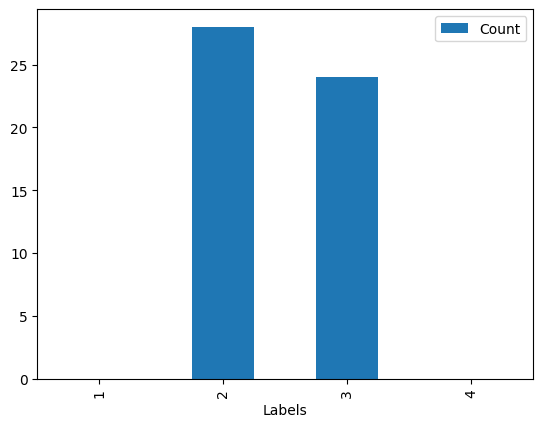

In [71]:
plot_category_answer_distribution(concat_df, category=0.0)

In [13]:
# To separate OG train ds values
dir_path = r"/home/pedke/multi-task-learning/wandb/run-20231011_220122-waox82id"
mode = 'train'
epoch = 39
body_part = 'Glans'

concat_df = separate_train_results(dir_path, mode, epoch, body_part, print_output=False)

Diff
1.0    73
0.0    67
2.0    15
Name: count, dtype: int64
